In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate 
import time 
import os, sys

likelihood_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0, likelihood_path)
print('Setting as working directory: ', likelihood_path)

from likelihood.cobaya_interface import EuclidLikelihood

Setting as working directory:  /home/matteo/Projects/EUCLID/LIKELIHOOD/my_branch


In [2]:
def order(inivec):
    
    ells = np.logspace(np.log10(10),np.log10(5000),20)
    bins = 10
    
    Celldict = {str(bin1+1)+'x'+str(bin2+1): np.zeros((len(ells))) for bin1 in range(bins) 
                for bin2 in range(bin1,bins)}
    
    i=0
    for ind,ell in enumerate(ells):
        for bin1 in range(bins):
            for bin2 in range(bin1,bins):
                Celldict[str(bin1+1)+'x'+str(bin2+1)][ind] = inivec[i]
                i += 1
                
    return Celldict


def changebasis(cosmopars):
    
    import camb
    from copy import deepcopy
    
    tokeep = ['ombh2','omch2','H0','ns','As','w','wa']

    cambpars = deepcopy(cosmopars)
    cambpars.update({'num_nu_massive': 1,
                     'num_nu_massless': 2.046,
                     'mnu': 0.06})

    cambpars['ombh2'] = cambpars.pop('Omegab')*cosmopars['h']**2
    cambpars['H0']    = cambpars.pop('h')*100

    Neff               = cambpars['num_nu_massive']+cambpars['num_nu_massless']
    neutrino_mass_fac  = 94.07
    onu                = cambpars['mnu']/neutrino_mass_fac*(Neff/3)** 0.75
    cambpars['omch2']  = cambpars.pop('Omegam')*(cambpars['H0']/100)**2-cambpars['ombh2']-onu
    
    finalpars = {key: cambpars[key] for key in cambpars if key in tokeep}

    return finalpars

## loading benchmark output

In [3]:
num_model = 1

inipars   = []
winnyvals = []
omvals    = []



fiducial = {'Omegab': 0.05,
            'Omegam': 0.32,
            'h': 0.67,
            'ns': 0.96,
            'As': 2.12605e-9,
            'w': -1.,
            'wa': 0.}

winnyvals.append(0.001)
omvals.append(0.32)
inipars.append(changebasis(fiducial))

## Setting up generic dictionary

In [4]:
info = {
    'params': {
        'ombh2': 0.022445,
        'omch2': 0.1205579307,
        'H0': 67,
        'ns': 0.96,
        'As': 2.12605e-9,
        'w': -1.,
        'wa': 0.,
        'tau': 0.0925,
        'mnu': 0.06,
        'nnu': 3.046, 
        'omk': 0.0, 
        'omegam': None,
        'omegab': None,
        'omeganu': None,
        'omnuh2': None,
        'omegac': None,
        'N_eff': None,
        'like_selection': 1,
        'full_photo': False,
        'b1_photo': 1.0997727037892875,
        'b2_photo': 1.220245876862528,
        'b3_photo': 1.2723993083933989,
        'b4_photo': 1.316624471897739,
        'b5_photo': 1.35812370570578,
        'b6_photo': 1.3998214171814918,
        'b7_photo': 1.4446452851824907,
        'b8_photo': 1.4964959071110084,
        'b9_photo': 1.5652475842498528,
        'b10_photo': 1.7429859437184225,
        'b1_spec': 1.46,
        'b2_spec': 1.61,
        'b3_spec': 1.75,
        'b4_spec': 1.90},
    'theory': {'camb': 
               {'stop_at_error': True, 
                'extra_args':{'num_massive_neutrinos': 1,
                              'dark_energy_model': 'ppf',
                              'AccuracyBoost': 2}}},
    'sampler': {'evaluate': None},  
    'likelihood': {'Euclid': EuclidLikelihood},
    'force': True
    }

## IST computation

The values of the cosmological parameters are overwritten using those of the benchmark

In [5]:
from cobaya.model import get_model

like = EuclidLikelihood()
like.initialize()
ISTdatavecGC = like.likefinal.photodatafinal['GC-Phot']
ISTdatavecWL = like.likefinal.photodatafinal['WL']

ISTthvecGC = []
ISTthvecWL = []
ISTvals    = []
for ind in range(num_model):
    print('')
    print('Doing Model '+str(ind))
    print('')
    for key in inipars[ind]:
        info['params'][key] = inipars[ind][key]
    model = get_model(info)
    logposterior = model.logposterior({})
    like.passing_requirements(model, **model.provider.params)
    like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], 0.05)
    like.likefinal.loglike(like.cosmo.cosmo_dic, like.fiducial_cosmology.cosmo_dic)
    ISTthvecGC.append(like.likefinal.photothvec['GC-Phot'])
    ISTthvecWL.append(like.likefinal.photothvec['WL'])
    ISTvals.append(-2*like.likefinal.loglike_tot)
    print('check zero',-2*logposterior.logpost-ISTvals[ind])

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *global* CAMB.
[camb] Initialized!
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *global* CAMB.
[camb] Initialized!

Doing Model 0

[model] *WARNING* Ignored blocks/options: ['sampler', 'force']
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *global* CAMB.
[camb] Initialized!
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *global* CAMB.
[camb] Initialized!
check zero 0.0


## $C_\ell$ comparison with benchmark

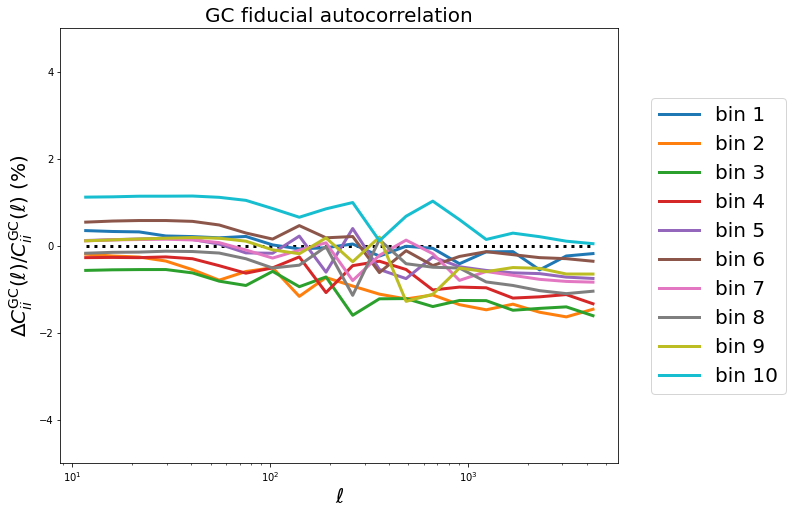

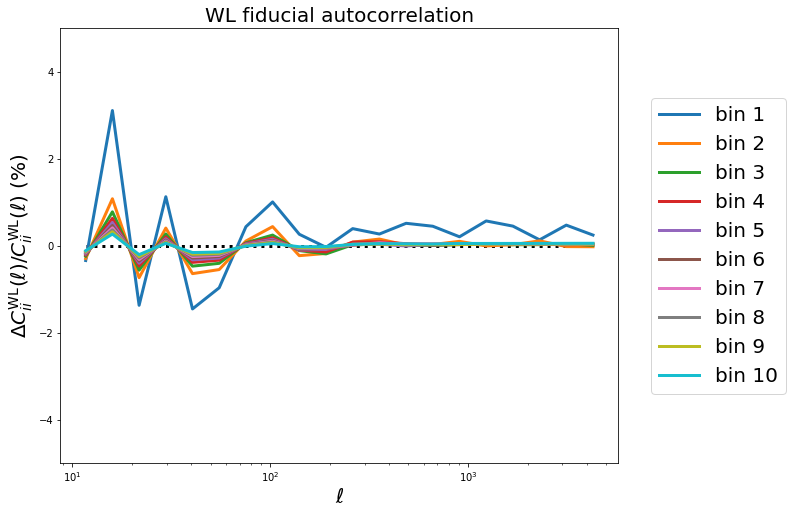

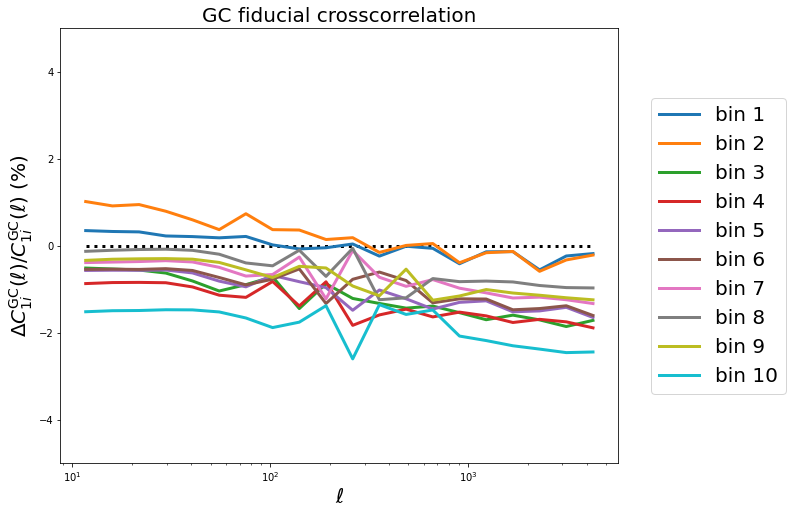

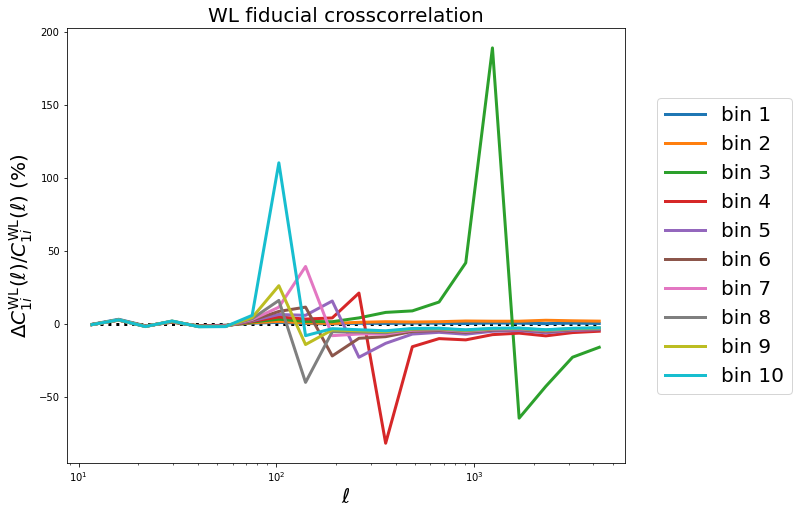

In [6]:
pathcls = '../data/ExternalBenchmark/Photometric/'


benchGC = np.genfromtxt(pathcls+'CijGG-LCDM-Lin-zNLA.dat')
benchWL = np.genfromtxt(pathcls+'CijLL-LCDM-Lin-zNLA.dat')


clwl = {}
clgc = {}
i = 1
for bin1 in range(1,11):
    for bin2 in range(bin1,11):
        clwl[str(bin1)+'x'+str(bin2)] = benchWL[:,i]
        clgc[str(bin1)+'x'+str(bin2)] = benchGC[:,i]
        i += 1



eltest = benchWL[:,0]

ells = benchWL[:,0]

fac = ells*(ells+1)

for ind in range(num_model):
    plt.figure(figsize=(10,8))
    plt.title(r'GC fiducial autocorrelation',fontsize=20)
    for bin1 in range(1,11):
        reldiff = ((clgc[str(bin1)+'x'+str(bin1)] - order(ISTthvecGC[ind])[str(bin1)+'x'+str(bin1)])/
                   clgc[str(bin1)+'x'+str(bin1)])
        plt.plot(ells,100*reldiff,lw=3,label='bin '+str(bin1))
    plt.xlabel(r'$\ell$',fontsize=20)
    plt.ylabel(r'$\Delta C_{ii}^{\rm GC}(\ell)/C_{ii}^{\rm GC}(\ell)$ (%)',fontsize=20)
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)
    plt.hlines(0,ells[0],ells[-1],color='black',lw=3,ls=':')
    plt.ylim([-5,5])
    plt.xscale('log')


    plt.figure(figsize=(10,8))
    plt.title(r'WL fiducial autocorrelation',fontsize=20)
    for bin1 in range(1,11):
        reldiff = ((clwl[str(bin1)+'x'+str(bin1)] - order(ISTthvecWL[ind])[str(bin1)+'x'+str(bin1)])/
                   clwl[str(bin1)+'x'+str(bin1)])
        plt.plot(ells,100*reldiff,lw=3,label='bin '+str(bin1))
    plt.xlabel(r'$\ell$',fontsize=20)
    plt.ylabel(r'$\Delta C_{ii}^{\rm WL}(\ell)/C_{ii}^{\rm WL}(\ell)$ (%)',fontsize=20)
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)
    plt.hlines(0,ells[0],ells[-1],color='black',lw=3,ls=':')
    plt.ylim([-5,5])
    plt.xscale('log')
    

    plt.figure(figsize=(10,8))
    plt.title(r'GC fiducial crosscorrelation',fontsize=20)
    for bin1 in range(1,11):
        reldiff = ((clgc['1x'+str(bin1)] - order(ISTthvecGC[ind])['1x'+str(bin1)])/
                   clgc['1x'+str(bin1)])
        plt.plot(ells,100*reldiff,lw=3,label='bin '+str(bin1))
    plt.xlabel(r'$\ell$',fontsize=20)
    plt.ylabel(r'$\Delta C_{1i}^{\rm GC}(\ell)/C_{1i}^{\rm GC}(\ell)$ (%)',fontsize=20)
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)
    plt.hlines(0,ells[0],ells[-1],color='black',lw=3,ls=':')
    plt.ylim([-5,5])
    plt.xscale('log')

    
    
    plt.figure(figsize=(10,8))
    plt.title(r'WL fiducial crosscorrelation',fontsize=20)
    for bin1 in range(1,11):
        reldiff = ((clwl['1x'+str(bin1)] - order(ISTthvecWL[ind])['1x'+str(bin1)])/
                   clwl['1x'+str(bin1)])
        plt.plot(ells,100*reldiff,lw=3,label='bin '+str(bin1))
    plt.xlabel(r'$\ell$',fontsize=20)
    plt.ylabel(r'$\Delta C_{1i}^{\rm WL}(\ell)/C_{1i}^{\rm WL}(\ell)$ (%)',fontsize=20)
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)
    plt.hlines(0,ells[0],ells[-1],color='black',lw=3,ls=':')
    plt.xscale('log')

## Compare $\chi^2$

In [7]:
print('CHI2 VALUES')
print('Benchmark: {}'.format(winnyvals[0]))
print('IST: {}'.format(ISTvals[0]))

CHI2 VALUES
Benchmark: 0.001
IST: 2824.635168050518
